In [1]:

import shutil
import matplotlib.pyplot as plt
import os
import sys
from targets.fire_occurrence_target import FireOccurrenceTarget
from pathlib import Path
from boundaries.canada_boundary import CanadaBoundary
from data_sources.canada_boundary_data_source import CanadaBoundaryDataSource
from data_sources.nbac_fire_data_source import NbacFireDataSource
from preprocessing.tiles_preprocessor import TilesPreprocessor
from grid.square_meters_grid import SquareMetersGrid
from osgeo import gdal
from loguru import logger

In [2]:
logger.remove()
format_string = (
    "{time:YYYY-MM-DD HH:mm:ss.SSS} | {level} | {name} | {message} | {extra}"
)
debug = True
logger.add(
    sys.stdout,
    format=format_string,
    colorize=True,
    level="DEBUG" if debug else "INFO",
)

1

In [3]:
async def preview_targets():
    target_srid = 3978
    target_pixel_size_in_meters = 250
    tile_size_in_pixels = 512
    tmp_output_path_base = Path("../data/tmp/")
    years_ranges = [range(a, a+1) for a in range(2021, 2024) ]
    target_output_format = "GTiff"

    canada_output_path = tmp_output_path_base / "canada_boundary/"
    canada_boundary = CanadaBoundary(CanadaBoundaryDataSource(canada_output_path), target_epsg=target_srid)
    canada_boundary.load(["NL", "PE", "NS", "NB", "QC", "ON", "MB", "SK", "AB", "BC"])

    fire_data_source = NbacFireDataSource(tmp_output_path_base)

    target = FireOccurrenceTarget(
        fire_data_source=fire_data_source,
        boundary=canada_boundary,
        target_pixel_size_in_meters=target_pixel_size_in_meters,
        target_srid=target_srid,
        output_folder_path=tmp_output_path_base / "fake_target_real_output_path/",
        output_format=target_output_format,
        max_io_concurrency=16,
        max_cpu_concurrency=max(1, len(os.sched_getaffinity(0)) - 1),
    )

    result = await target.generate_target_for_years_ranges(years_ranges)

    logger.debug(result)

    grid = SquareMetersGrid(pixel_size_in_meters=target_pixel_size_in_meters, tile_size_in_pixels=tile_size_in_pixels)

    logger.info("Computing tiles boundaries")

    big_tiles_boundaries = grid.get_tiles_boundaries(canada_boundary.boundary)

    logger.info("Generating tiles")

    for years_range, path in result.items():
        output_folder = tmp_output_path_base / f"{years_range[0]}_{years_range[-1]}/"
        
        tiles_preprocessor = TilesPreprocessor(
            raw_tiles_folder=path.parent,
            tile_size_in_pixels=tile_size_in_pixels,
            pixel_size_in_meters=target_pixel_size_in_meters,
            output_folder=output_folder,
            big_tiles_boundaries=big_tiles_boundaries,
            input_format=target_output_format,
            output_format=target_output_format,
            source_srid=target_srid,
            target_srid=target_srid,
            resample_algorithm_continuous="lanczos",
            resample_algorithm_categorical="nearest"
        )

        tiles_paths = await tiles_preprocessor.preprocess_tiles(data_type="categorical")
        
        fig, ax = plt.subplots(figsize=(8, 12))
        canada_boundary.boundary.plot(ax=ax, edgecolor='r', facecolor='none', lw=0.5)
        ax.set_title(f"Fire Target Years Range: {years_range}")

        minx, miny, maxx, maxy = canada_boundary.boundary.total_bounds
        boundary_extent = [minx, maxx, miny, maxy]
        
        target_ds = gdal.Open(str(path))
        target_band = target_ds.GetRasterBand(1)
        target_data = target_band.ReadAsArray()
        
        ax.imshow(target_data, extent=boundary_extent, cmap='binary', alpha=1)
        
        for tile_path in tiles_paths:
            tile_ds = gdal.Open(str(tile_path))
            
            geotransform = tile_ds.GetGeoTransform()
            top_left_x = geotransform[0]
            top_left_y = geotransform[3]
            bot_right_x = top_left_x + geotransform[1] * tile_ds.RasterXSize
            bot_right_y = top_left_y + geotransform[5] * tile_ds.RasterYSize
            
            rect = plt.Rectangle((top_left_x, bot_right_y), bot_right_x - top_left_x, top_left_y - bot_right_y,
                                linewidth=0.15, edgecolor='b', facecolor='none')
            ax.add_patch(rect)
        
        del target_ds

    shutil.rmtree(tmp_output_path_base)
    plt.show()

2024-08-11 14:41:22.952 | INFO | data_sources.canada_boundary_data_source | Downloading canada boundary shapefile... | {}


ERROR 1: PROJ: proj_create_from_database: Open of /home/user/micromamba/envs/wildfire/share/proj failed


2024-08-11 14:41:30.396 | INFO | targets.fire_occurrence_target | Downloading fire polygons for all 3 years... | {}
2024-08-11 14:41:30.397 | DEBUG | targets.fire_occurrence_target | RAM Usage : 58.1/100 | {}
2024-08-11 14:41:30.400 | INFO | data_sources.nbac_fire_data_source | Downloading NBAC fire polygons data for year 2022... | {}
2024-08-11 14:41:30.400 | INFO | data_sources.nbac_fire_data_source | Downloading NBAC fire polygons data for year 2021... | {}
2024-08-11 14:41:30.404 | INFO | data_sources.nbac_fire_data_source | Downloading NBAC fire polygons data for year 2023... | {}
2024-08-11 14:41:59.621 | INFO | targets.fire_occurrence_target | Computing output bounds based on boundary... | {}
2024-08-11 14:41:59.622 | DEBUG | targets.fire_occurrence_target | RAM Usage : 67.0/100 | {}
2024-08-11 14:41:59.623 | INFO | targets.fire_occurrence_target | Final raster will have dimensions (10893 x 21407) pixels | {}
2024-08-11 14:41:59.624 | INFO | targets.fire_occurrence_target | Rast

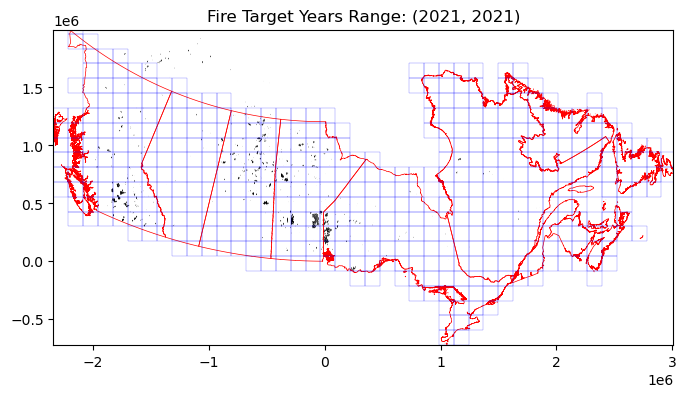

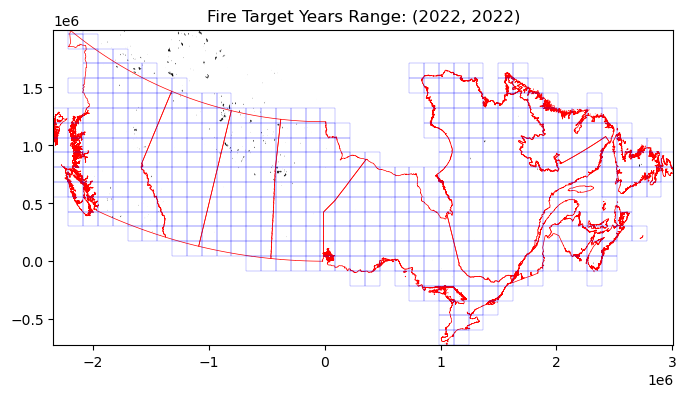

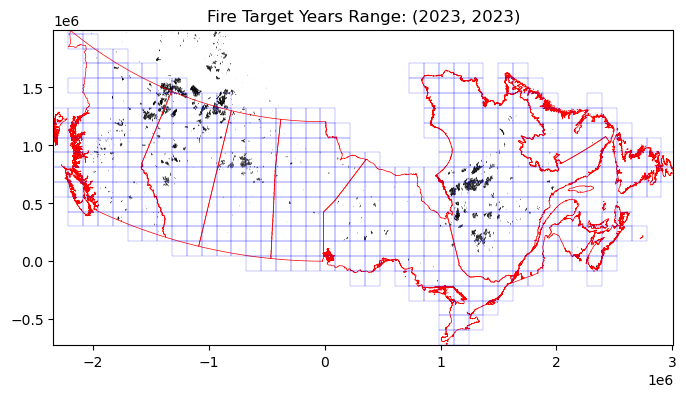

In [4]:
await preview_targets()